# Weather Changes Over Time (Consuming APIs)

## Task
Utilize the following two APIs to evaluate the changes in temperature for your birthday and city you were born in:
* [geocode.xyz](geocode.xyz)
* [open-meteo.com](open-meteo.com)


In [2]:
from datetime import date, datetime, timedelta
import http.client, urllib.parse

import requests
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

sns.set_palette('muted')
sns.set_style('white')

## Question 1: Geocoding A Location

> Indented block


Write a function that utilizes the [geocode.xyz](geocode.xyz) API to take in a city and country and return the latitude and longitude of that location

```
def geocode_location(city, country):
    # your code
    return latitude, longitude
```

For example:
```
geocode_location("london", "united kingdom")
```
should return
```
(51.49742, -0.11534)
```

In [9]:
# write your solution here
import json
def geocode_location(city, country):
    conn = http.client.HTTPConnection('geocode.xyz')
    
    params = urllib.parse.urlencode({
        'locate': f'{city}, {country}',
        'region': country,
        'json': 1,
        })
    
    conn.request('GET', '/?{}'.format(params))
    
    res = conn.getresponse()
    data = res.read()
    
    response = json.loads(data)

    if 'latt' in response and 'longt' in response:
        if 'Throttled' in response['latt'] or 'Throttled' in response['longt']:
            return 38.74283, -77.46946 # getting throttled crashes everything, backup hardcode
        latitude = float(response['latt'])
        longitude = float(response['longt'])
        return latitude, longitude
    else:
        return None, None

lat, lon = geocode_location('Manassas, VA', 'USA')
print(lat, lon)

38.74283 -77.46946


## Question 2: Determining Weather Using Date and Location
Write a function that utilizes the [open-meteo.com](https://open-meteo.com/) API to take in a date and location and return the 15-day average high and low for the following measurements from the years 1960 to 2022:
* `precipitation_sum` (mm): Sum of daily precipitation (including rain, showers and snowfall)
* `temperature_2m_max` (°F): Maximum daily air temperature at 2 meters above ground
* `temperature_2m_min` (°F): Minimum daily air temperature at 2 meters above ground
* `apparent_temperature_max` (°F): Maximum daily apparent temperature
* `apparent_temperature_min` (°F): Min daily apparent temperature

The function should return the above measurements in a dictionary object with the keys being `"precipitation_sum"`, `"temperature_2m_max"`, etc. and the values being the 15-day average of the measurements. The 15-day average should be the 7 days preceeding the input date, the input date, and the 7 days following the input date. This will give the results more statistical validity by increasing the number of samples for each measurement.

The `get_historical_weather_measurements()` function will include a few different sub-tasks:

### Create API Request in Postman/Insomnia
Use the following [API Documentation](https://open-meteo.com/en/docs/historical-weather-api#api-documentation) page to create an API request that responds with a JSON object of the measurements listed above. Make sure the response object meets the following:
* Temperatue measurements are in Fahrenheit
* Precipitation measurements are in inches
* Measurements are daily aggregations
* 15 day range of weather
* JSON format

Before writing any code, use Postman/Insomnia to create the API request and take a screenshot of the request/response.

#### HINT: How to insert a screenshot
1. Take a screenshot and save it to a file.
2. Create a markdown cell in your notebook.
3. Insert the image into the markdown cell.
  * Option 1: Drag the image file into the markdown cell. This embeds the image data directly into your Jupyter notebook.
  * Option 2: Move the file into the directory with your notebook file (inside the project folder that you will submit). Add markdown to insert the image: `![alternative text](path-to-image)`

### Create API Request Function
Convert the request above into a function. The function should take in `latitude`, `longitude`, and `date` as its arguments and return the API response, if successful.

```
def get_api_response(latitude, longitude, date):
    # your code

```

Use the helper function below for creating a 15-day date range

In [53]:
# helper function for 15-day date range
def get_date_range(birthday):
    return {'start_date': (birthday - timedelta(days=7)).strftime('%Y-%m-%d'),
            'end_date': (birthday + timedelta(days=7)).strftime('%Y-%m-%d')
        }

In [65]:
# write your solution here
def get_api_response(latitude, longitude, date):
    date_range = get_date_range(date)
    
    # Construct the API endpoint with the parameters
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'start_date': date_range['start_date'],
        'end_date': date_range['end_date'],
        'daily': 'precipitation_sum,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min',
        'timezone': 'auto'
    }
    
    # Make the API request
    response = requests.get(url, params=params)
    
    # Check for successful response
    if response.status_code != 200:
        print(f"Error: Received status code {response.status_code}")
        print(f"Response content: {response.text}")
        raise Exception(f"API request failed with status code {response.status_code}")
            # This came in very handy to realize when I had the wrong URL and bad dates
   
    return response.json()

### Iterating Over Each Year
Write a function that iterates through each year between 1960 and 2022 and returns the corresponding JSON response objects containing weather data for each year in a python list.

```
def get_all_response_objects(start_year, end_year):
    # your code
```


In [123]:
# write your solution here
def get_all_response_objects(latitude, longitude, date):
    responses = []

    # Go through each year
    for year in range(1960, 2022 + 1):
        # Create the date
        current_date = datetime(year, date.month, date.day)

        # Get the API response for the current date
        response = get_api_response(latitude, longitude, current_date)
        
        # Append the response to the list
        responses.append(response)

    return responses

### Parse JSON Responses & Aggregate Data
Write a function that takes the list of JSON response objects from the previous function in as a parameter and returns a pandas DataFrame containing the original input date, the measurements, and the average across the 15 days.
```
def parse_json_response(responses):
    # your code
```


In [121]:
# write your solution here
def parse_json_response(responses):
    # Initialize lists to store data
    dates = []
    precipitation_sums = []
    temperature_maxes = []
    temperature_mins = []
    apparent_temperature_maxes = []
    apparent_temperature_mins = []

    # Iterate through each response object
    for response in responses:
        daily_data = response.get('daily', {})
        dates.extend(daily_data.get('time', []))
        precipitation_sums.extend(daily_data.get('precipitation_sum', []))
        temperature_maxes.extend(daily_data.get('temperature_2m_max', []))
        temperature_mins.extend(daily_data.get('temperature_2m_min', []))
        apparent_temperature_maxes.extend(daily_data.get('apparent_temperature_max', []))
        apparent_temperature_mins.extend(daily_data.get('apparent_temperature_min', []))

    # Create a df from the collected data
    df = pd.DataFrame({
        'date': dates,
        'precipitation_sum': precipitation_sums,
        'temperature_2m_max': temperature_maxes,
        'temperature_2m_min': temperature_mins,
        'apparent_temperature_max': apparent_temperature_maxes,
        'apparent_temperature_min': apparent_temperature_mins,
    })

    # Utterly painful to sort by year, then average
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    yearly_avg = df.groupby('year').mean().reset_index()
    df = df.merge(yearly_avg, on='year', suffixes=('', '_avg'))

    return df

### Combining the Functions
Write a function that combines all the above functions into one, where the user inputs their birthday and location and the function returns the pandas DataFrame containing the summary of measurements.

```
def get_data():
    birthday = get_user_birthday()
    location = get_user_city_of_birth()
    # your code here
```

The helper functions below can be used for birthday and location input information:

In [19]:
# helper functions
def get_user_birthday():
    birthday = input('Enter your birthday (MM/DD/YYYY): ')
    return datetime.strptime(birthday, "%m/%d/%Y")

def get_user_city_of_birth():
    city = input('Enter the city you were born in: ')
    country = input('Enter the country you were born in: ')
    return city , country

In [119]:
# write your solution here
def get_data():
    # Get user input for birthday and location
    birthday = get_user_birthday()
    city, country = get_user_city_of_birth()
    
    # Geocode the location to get latitude and longitude
    latitude, longitude = geocode_location(city, country)
    
    # Get all response objects for birthday from 1960 to 2022
    all_responses = get_all_response_objects(latitude, longitude, birthday)
    
    # Parse the JSON responses into a DataFrame
    df = parse_json_response(all_responses)
    
    # Return the DataFrame
    return df

Run your function and set it equal to `df`:

In [125]:
df = get_data()

df.head()

Enter your birthday (MM/DD/YYYY):  07/28/1998
Enter the city you were born in:  Manassas, VA
Enter the country you were born in:  USA


,date,precipitation_sum,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,year,date_avg,precipitation_sum_avg,temperature_2m_max_avg,temperature_2m_min_avg,apparent_temperature_max_avg,apparent_temperature_min_avg
0,1960-07-21,0.0,29.1,18.5,30.6,17.5,1960,1960-07-28,5.146667,30.673333,20.42,33.34,22.0
1,1960-07-22,0.0,31.3,18.0,32.4,18.8,1960,1960-07-28,5.146667,30.673333,20.42,33.34,22.0
2,1960-07-23,0.0,35.4,20.9,37.4,22.5,1960,1960-07-28,5.146667,30.673333,20.42,33.34,22.0
3,1960-07-24,0.0,33.2,22.9,34.6,24.1,1960,1960-07-28,5.146667,30.673333,20.42,33.34,22.0
4,1960-07-25,0.0,32.5,21.1,35.3,21.1,1960,1960-07-28,5.146667,30.673333,20.42,33.34,22.0


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          945 non-null    datetime64[ns]
 1   precipitation_sum             945 non-null    float64       
 2   temperature_2m_max            945 non-null    float64       
 3   temperature_2m_min            945 non-null    float64       
 4   apparent_temperature_max      945 non-null    float64       
 5   apparent_temperature_min      945 non-null    float64       
 6   year                          945 non-null    int32         
 7   date_avg                      945 non-null    datetime64[ns]
 8   precipitation_sum_avg         945 non-null    float64       
 9   temperature_2m_max_avg        945 non-null    float64       
 10  temperature_2m_min_avg        945 non-null    float64       
 11  apparent_temperature_max_avg  94

## Question 3: Visualizing The Data
Plot the DataFrame using `matplotlib`/`seaborn` and write a short summary of your results.

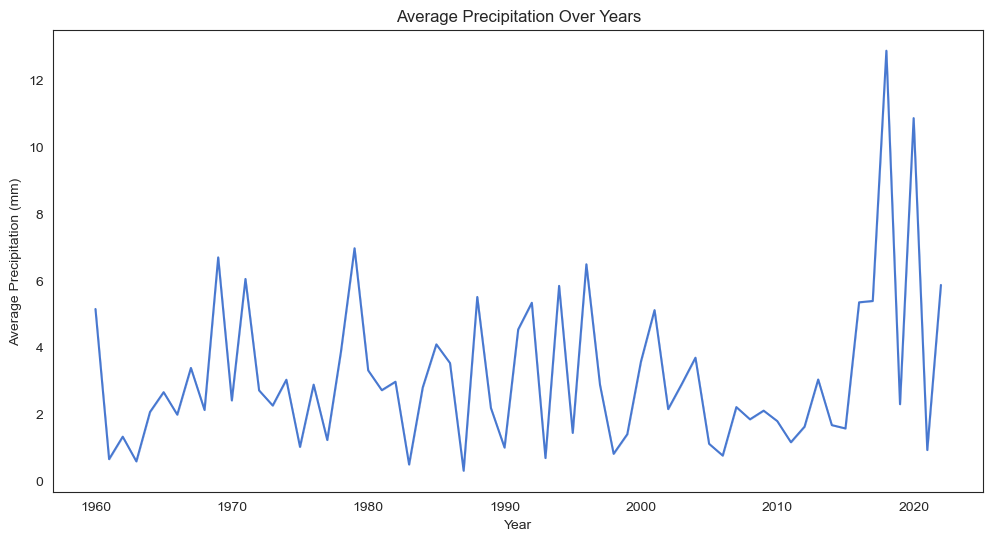

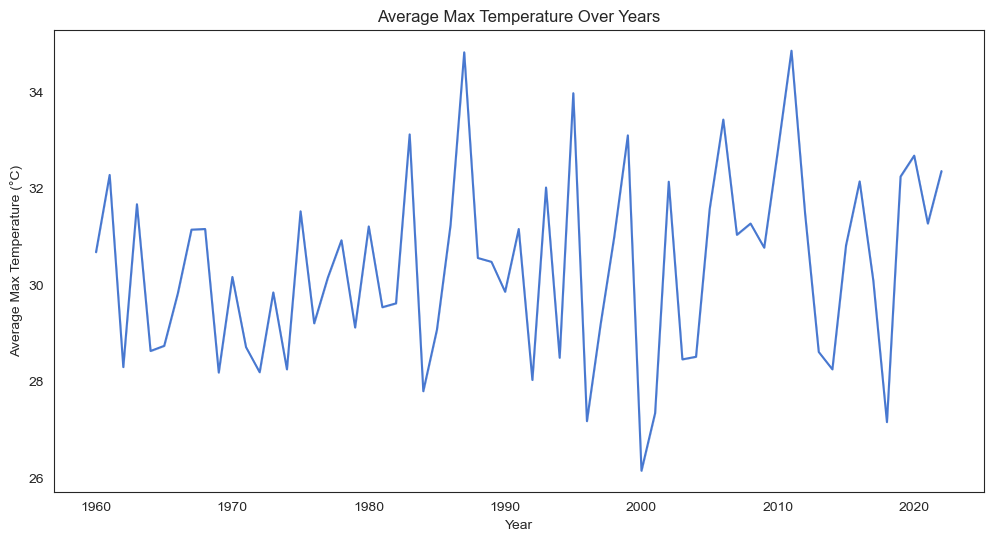

In [129]:
# Line plot for average precipitation over the years
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='year', y='precipitation_sum_avg')
plt.title('Average Precipitation Over Years')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm)')
plt.show()

# Line plot for average max temperature over the years
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='year', y='temperature_2m_max_avg')
plt.title('Average Max Temperature Over Years')
plt.xlabel('Year')
plt.ylabel('Average Max Temperature (°C)')
plt.show()

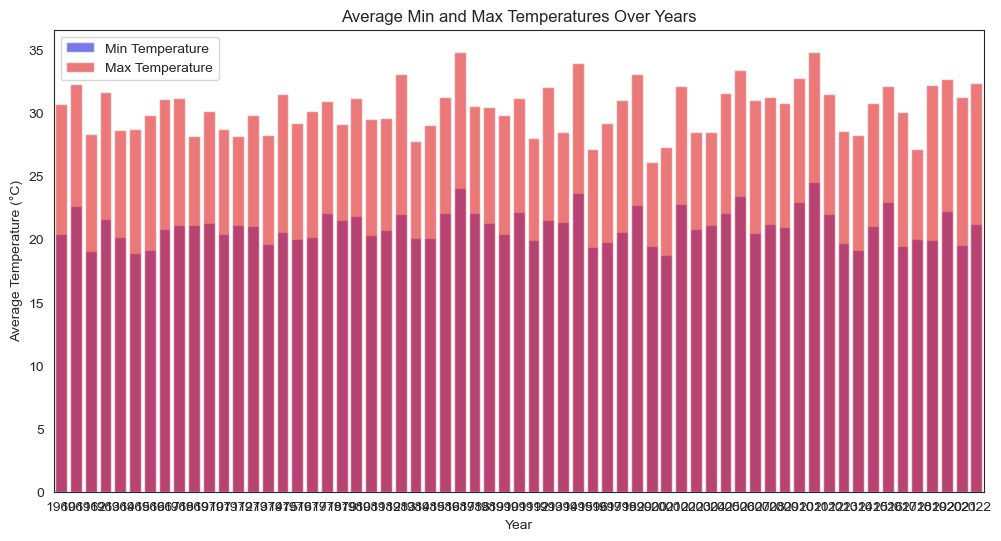

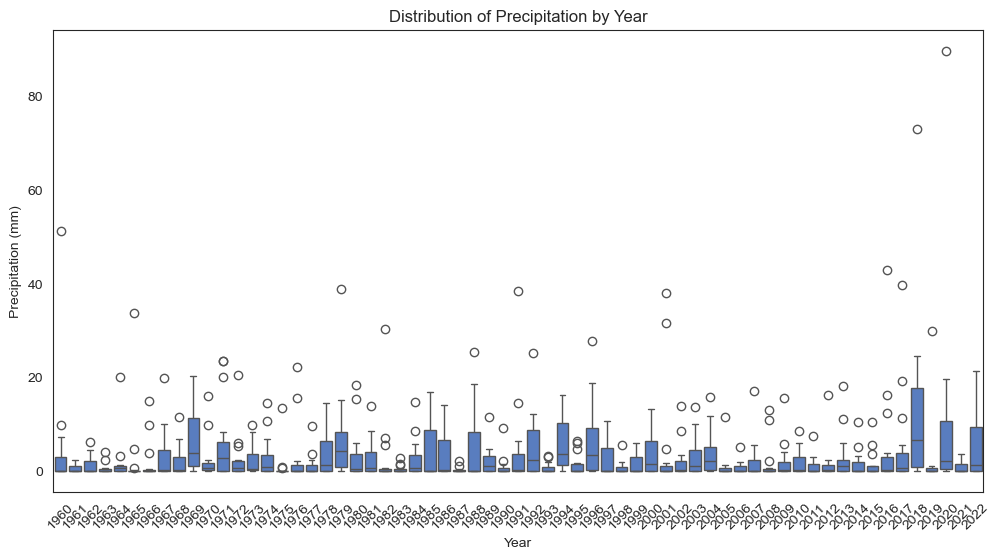

In [112]:
# Bar plot for average min and max temperatures
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='year', y='temperature_2m_min_avg', color='blue', label='Min Temperature', alpha=0.6)
sns.barplot(data=df, x='year', y='temperature_2m_max_avg', color='red', label='Max Temperature', alpha=0.6)
plt.title('Average Min and Max Temperatures Over Years')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()
# Box plot for preciptation
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='year', y='precipitation_sum')
plt.title('Distribution of Precipitation by Year')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.xticks(rotation=45)
plt.show()

### Results Summary:

While I can't see anything truly unbelievable, the average precipitation graph told me the late 2010's were unusually rainy around my birthday.

Lots of fluctation around the max temp over the years, but the overlaid bar chart for the temps illustrates better that the variation with within a 15 degree range, which doesn't look as crazy with peaks and dips line the line chart. It does seem to follow a typical pattern of alternation however, zig-zagging about.

The minimum temp change seems to follow the max closely, making a very similiar if not more muted graph of the same changes. 

I will be honest, and say I'm still not sure how to 100% read a boxplot and pull every bit of info out of it, but there seems to be some precipitation peaks within 5-10 year spans, with something in the more later years after 2015 is very high up there.